{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}


<ipython-input-1-da8aa2966c93>:30: RuntimeWarning: invalid value encountered in true_divide
  precision = np.round_(TP/(TP+FP),2)
C:\Users\noahf\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
<ipython-input-1-da8aa2966c93>:30: RuntimeWarning: invalid value encountered in true_divide
  precision = np.round_(TP/(TP+FP),2)
C:\Users\noahf\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\noahf\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\noahf\anaconda3\lib\site-packages\s

{'activation': 'identity', 'hidden_layer_sizes': (10, 10, 10), 'solver': 'sgd'}


<ipython-input-1-da8aa2966c93>:30: RuntimeWarning: invalid value encountered in true_divide
  precision = np.round_(TP/(TP+FP),2)
<ipython-input-1-da8aa2966c93>:32: RuntimeWarning: invalid value encountered in true_divide
  F1 = np.round_(2 * (precision * recall) / (precision + recall),2)


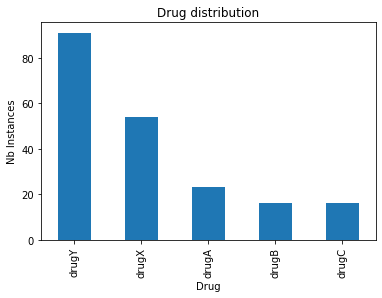

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
performanceFile = open('drugs-performance.txt', "a")


def printPerformance(actual, predicted, classifier):
    confusionMatrix = metrics.confusion_matrix(actual,predicted,labels=['drugA','drugB','drugC','drugX','drugY'])
    accuracy = metrics.accuracy_score(actual,predicted)
    macroF1 = metrics.f1_score(actual,predicted,labels=['drugA','drugB','drugC','drugX','drugY'],average="macro")
    weightedF1 = metrics.f1_score(actual,predicted,labels=['drugA','drugB','drugC','drugX','drugY'],average="weighted")
    TP = np.diagonal(confusionMatrix)
    FP = np.sum(confusionMatrix,axis=0) - TP
    FN = np.sum(confusionMatrix,axis=1) - TP

    TN = []
    for i in range(5):
        temp = np.delete(confusionMatrix,i,0)
        temp = np.delete(temp,i,1)
        TN.append(sum(sum(temp)))

    precision = np.round_(TP/(TP+FP),2)
    recall =  np.round_(TP/(TP+FN))
    F1 = np.round_(2 * (precision * recall) / (precision + recall),2)

    performanceFile.writelines([
        '----------------------------------------------\n',
        classifier + '\n',
        '----------------------------------------------\n',
        'ConfusionMatrix:\n\n',
        str(confusionMatrix) + '\n\n',
        'DrugA => Precision=' + str(precision[0]) + ', Recall=' + str(recall[0]) + ', F1=' + str(F1[0]),
        '\nDrugB => Precision=' + str(precision[1]) + ', Recall=' + str(recall[1]) + ', F1=' + str(F1[1]),
        '\nDrugC => Precision=' + str(precision[2]) + ', Recall=' + str(recall[2]) + ', F1=' + str(F1[2]),
        '\nDrugX => Precision=' + str(precision[3]) + ', Recall=' + str(recall[3]) + ', F1=' + str(F1[3]),
        '\nDrugY => Precision=' + str(precision[4]) + ', Recall=' + str(recall[4]) + ', F1=' + str(F1[4]) + '\n\n',
        'Accuracy=' + str(accuracy) + '\n',
        'Macro-average F1=' + str(round(macroF1,2)) + '\n',
        'Weighted-average F1=' + str(round(weightedF1,2)),
        '\n'
        ])

# Retrieving data and creating distribution figure
df = pd.read_csv('./drug200.csv')
axes = df.Drug.value_counts().plot(kind='bar', title='Drug distribution')
axes.set_xlabel("Drug")
axes.set_ylabel("Nb Instances")
plt.savefig('drug-distribution.pdf')

# Converting to numerical
le = LabelEncoder()
df.Sex = le.fit_transform(df.Sex)
df.BP = le.fit_transform(df.BP)
df.Cholesterol = le.fit_transform(df.Cholesterol)
y = df.pop('Drug')

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(df, y)

# Gaussian Naive Bayes run
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_predicted = gnb.predict(X_test)
printPerformance(y_test, y_predicted, 'a) Gaussian Naive Bayes')

# Base Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_predicted = dt.predict(X_test)
printPerformance(y_test, y_predicted, 'b) Base Decision Tree')

# Top Decision Tree
dtc = DecisionTreeClassifier()
params = {'min_samples_split' : [2,3,4], 'criterion' : ['gini','entropy'], 'max_depth' : [20,90]}
# First, determine best parameters using grid search
grid_search = GridSearchCV(estimator = dtc , param_grid = params)
grid_search.fit(X_train, y_train)
bestParams = grid_search.best_params_ 
print(bestParams)
#Second, predict using decision tree with best parameters
dt = DecisionTreeClassifier(criterion=bestParams["criterion"],max_depth=bestParams["max_depth"],min_samples_split=bestParams["min_samples_split"])
dt.fit(X_train, y_train)
y_predicted = dt.predict(X_test)
printPerformance(y_test, y_predicted, 'c) Top Decision Tree')

# Perceptron
pct = Perceptron()
pct.fit(X_train, y_train)
y_predicted = pct.predict(X_test)
printPerformance(y_test, y_predicted, 'd) Perceptron')

# Multi-Layered Perceptron
mlp = MLPClassifier(hidden_layer_sizes=(100,),activation='logistic', solver='sgd')
mlp.fit(X_train, y_train)
y_predicted = mlp.predict(X_test)
printPerformance(y_test, y_predicted, 'e) Multi-Layered Perceptron')

# Top Decision Tree
mlp = MLPClassifier()
params = {
    'hidden_layer_sizes': [(30,50,), (10,10,10)],
    'activation': ['tanh', 'identity','logistic','relu'],
    'solver': ['sgd', 'adam'],
}
# First, determine best parameters using grid search
grid_search = GridSearchCV(estimator = mlp , param_grid = params)
grid_search.fit(X_train, y_train)
bestParams = grid_search.best_params_ 
#Second, predict using MLP with best parameters
print(bestParams)
mlp = MLPClassifier(hidden_layer_sizes=bestParams['hidden_layer_sizes'],activation=bestParams['activation'],solver=bestParams['solver'])
mlp.fit(X_train, y_train)
y_predicted = mlp.predict(X_test)
printPerformance(y_test, y_predicted, 'f) Top Multi-Layered Perceptron')

performanceFile.close()